# Import Libraries and Mount Drive

In [ ]:
# making all necessary imports here
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Display Functions

In [ ]:
# display: displays a 3D matrix as an object
def display(obj):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(obj[0],obj[1],obj[2], c='b', marker='.')
  return

In [ ]:
def display2d(x):
  fig = plt.figure()
  plt.scatter(x[0],x[1])
  return

# Load 3D object

In [ ]:
# loadind the data file as x
x = loadmat('/content/drive/MyDrive/SPROJ/Camera Callibration/teapot.mat')

In [ ]:
# stack x,y,z coordinates vertically
X = np.transpose(x['verts'])
print(X.shape)

(3, 2082)


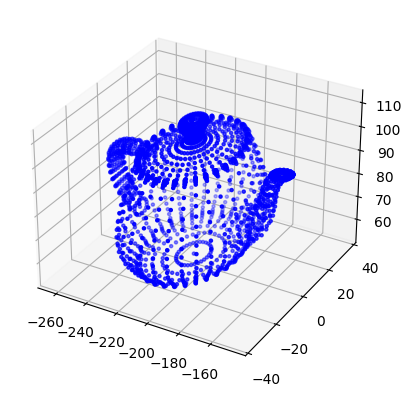

In [ ]:
display(X)

# Define Intrinsic Parameters

In [ ]:
# The default intrinsic paramters are set to an identity matrix
focal_length = 5.9
resolution = (0.07, 0.03) # (m_x, m_y)
principal_offset = (0, 0) # (p_x, p_y)

INTRINSIC_MATRIX = np.array([
    [resolution[0]*focal_length,  0,                          principal_offset[0]],
    [0,                           resolution[1]*focal_length, principal_offset[1]],
    [0,                           0,                          1                  ]
])

print('Intrinsic Matrix:',  '\n', INTRINSIC_MATRIX )

Intrinsic Matrix: 
 [[0.413 0.    0.   ]
 [0.    0.177 0.   ]
 [0.    0.    1.   ]]


In [ ]:
# Inverse of Intrinsic Matrix
INTRINSIC_MATRIX_INV = np.array([
    [1/(resolution[0]*focal_length)                   , 0,                                                  0],
    [0                                                , 1/(resolution[1]*focal_length),                     0],
    [-principal_offset[0]/(resolution[0]*focal_length), -principal_offset[1]/(resolution[1]*focal_length),  1]
])

print('Intrinsic Matrix Inverse:',  '\n', INTRINSIC_MATRIX_INV )

Intrinsic Matrix Inverse: 
 [[2.42130751 0.         0.        ]
 [0.         5.64971751 0.        ]
 [0.         0.         1.        ]]


# Simulation across 1 Dimension

## Rotation Matrix across 1 Dimension

In [ ]:
# rot: returns a rotation matrix of angle theta about the given axis.
def rot(axis, theta):
  theta = np.pi/180 * theta # convert to radians
  c = np.cos(theta)
  s = np.sin(theta)
  if axis == 0: # rotate about x-axis
    R = np.array([
        [1, 0,  0],
        [0, c, -s],
        [0, s,  c]
    ])
    return R
  elif axis == 1: # rotate about y-axis
    R = np.array([
        [c,  0, s],
        [0,  1, 0],
        [-s, 0, c]
    ])
    return R
  elif axis == 2: # rotate about z-axis
    R = np.array([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ])
    return R
  else:
    print ('Invalid axis arg...')
    return 

### Demo: Rotation across 1-D

In [ ]:
rotated_obj = np.matmul(rot(0, 23.5),X)
print(rotated_obj.shape)

(3, 2082)


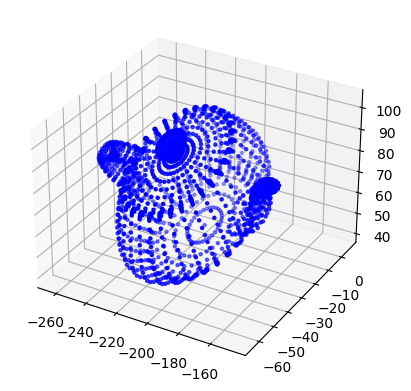

In [ ]:
display(rotated_obj)

## 3D to 2D Projection

In [ ]:
# proj2d: Takes a 3D object 'X' and projects it into 2D using the intrinsic matrix 'I' and extrinsic rotation matrix 'R'
def proj2d(X, R, I):
  T = np.matmul(I, R)
  X_proj = np.matmul(T, X)
  x_new = np.divide(X_proj[0], X_proj[2]) # x = hx/h
  y_new = np.divide(X_proj[1], X_proj[2]) # y = hy/h
  x = np.vstack((x_new, y_new))
  print(x.shape)
  return x

### Demo: 3D to 2D Projection

In [ ]:
x = proj2d(X, rot(0,23.5), INTRINSIC_MATRIX)

(2, 2082)


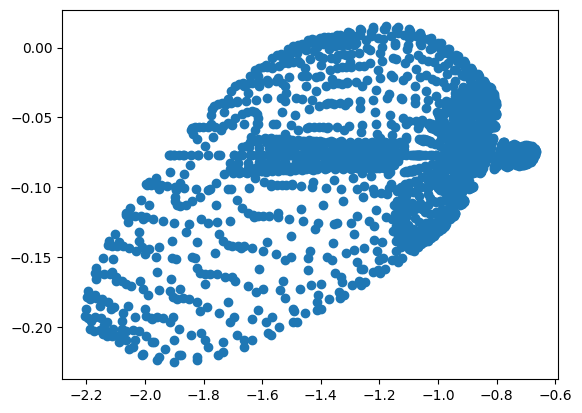

In [ ]:
display2d(x)

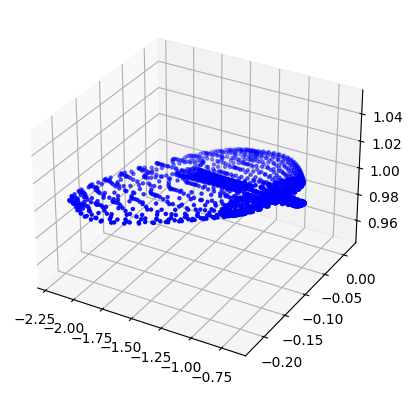

In [ ]:
z = np.ones((1, x.shape[1]))
x_3d = np.vstack((x, z))
display(x_3d)

## 2D to 3D Projection using Libraries

In [ ]:
def proj3d(x, R, I):
  R_inv = np.linalg.inv(R)
  I_inv = np.linalg.inv(I)
  T_inv = np.matmul(R_inv, I_inv)
  z = np.ones((1, x.shape[1]))
  x = np.vstack((x, z))
  X = np.matmul(T_inv, x)
  return X

### Demo: 2D to 3D Projection using Libraries

In [ ]:
X_new = proj3d(x, rot(0,23.5), INTRINSIC_MATRIX)
print(X_new.shape)

(3, 2082)


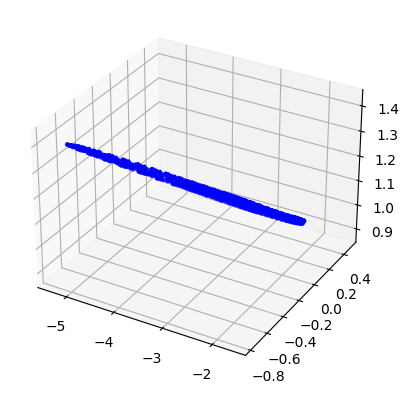

In [ ]:
display(X_new)

## 2D to 3D Projection - mathematical model

In [ ]:
R_inv = np.transpose(rot(0, 23.5))

In [ ]:
def projInv(x, R_inv, I_inv):
  T_inv = np.matmul(R_inv, I_inv)
  z = np.ones((1, x.shape[1]))
  x = np.vstack((x, z))
  X = np.matmul(T_inv, x)
  return X

### Demo: 2D to 3D Projection - mathematical model

In [ ]:
X_new_2 = projInv(x, R_inv, INTRINSIC_MATRIX_INV)
print(X_new_2.shape)

(3, 2082)


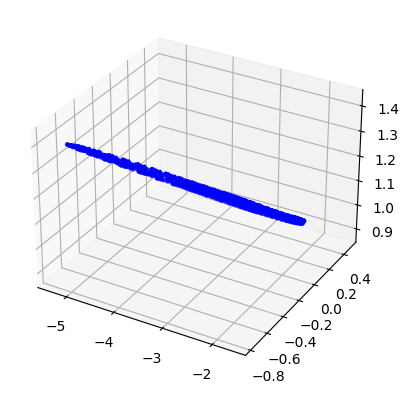

In [ ]:
display(X_new_2)

Check if the result from both transformations are the same.

In [ ]:
if np.array_equal(X_new, X_new_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are the same! :)


## Image to Image Projection using Libraries

Take two 2-D projections of the kettle:
1. The first one will have no rotation.
2. The second one will have 23.5 degrees rotation.
Project the first model onto the second one using the inverse model and compare the result with the second model.

In [ ]:
theta_1 = 0
theta_2 = 23.5

In [ ]:
model_1 = proj2d(X, rot(0,0), INTRINSIC_MATRIX)
model_2 = proj2d(X, rot(0,23.5), INTRINSIC_MATRIX)

(2, 2082)
(2, 2082)


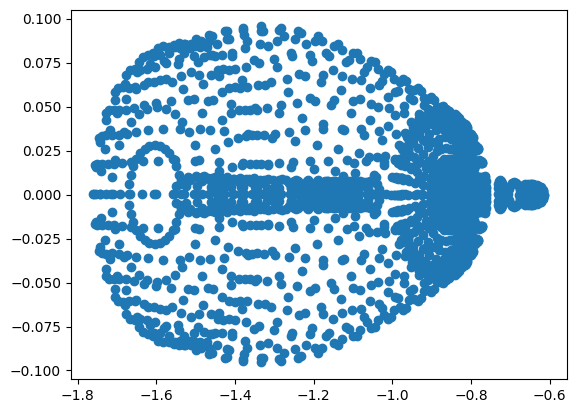

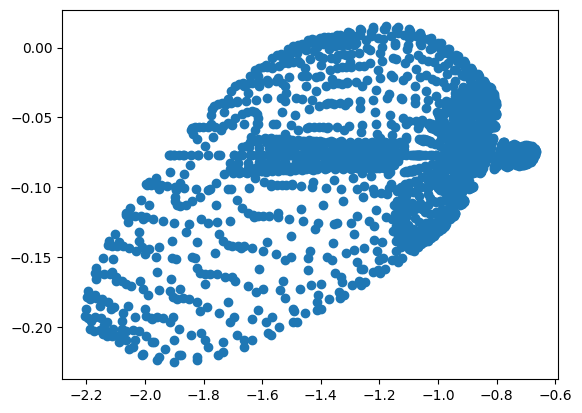

In [ ]:
display2d(model_1)
display2d(model_2)

In [ ]:
def img_proj(x_1, theta_1, theta_2):
  R = np.matmul(np.linalg.inv(rot(0, theta_1)), rot(0, theta_2))
  T = np.matmul(INTRINSIC_MATRIX, np.matmul(R, np.linalg.inv(INTRINSIC_MATRIX)))
  z = np.ones((1, x_1.shape[1]))
  x_1 = np.vstack((x_1, z))
  x = np.matmul(T, x_1)
  x_new = x[0]/ x[2]
  y_new = x[1]/ x[2]
  x_2 = np.vstack((x_new, y_new))
  return x_2

### Demo: Image to Image Projection using Libraries

In [ ]:
model_2_est = img_proj(model_1, theta_1, theta_2)
print(model_2_est.shape)

(2, 2082)


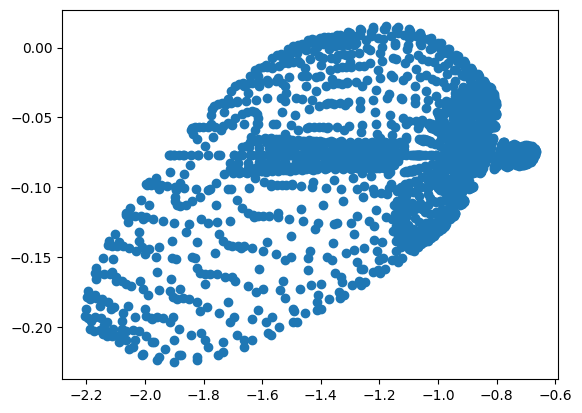

In [ ]:
display2d(model_2_est)

In [ ]:
if np.array_equal(model_2, model_2_est):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2, model_2_est)
print(mse)

8.116822014071173e-33


## Image to Image Projection using combined rotation

In [ ]:
R_combined = np.transpose(rot(0, theta_1-theta_2))
print(R_combined)

[[ 1.          0.          0.        ]
 [ 0.          0.91706007 -0.39874907]
 [ 0.          0.39874907  0.91706007]]


In [ ]:
def img_proj_2(x_1, R):
  T = np.matmul(INTRINSIC_MATRIX, np.matmul(R, np.linalg.inv(INTRINSIC_MATRIX)))
  z = np.ones((1, x_1.shape[1]))
  x_1 = np.vstack((x_1, z))
  x = np.matmul(T, x_1)
  x_new = x[0]/ x[2]
  y_new = x[1]/ x[2]
  x_2 = np.vstack((x_new, y_new))
  return x_2

### Demo: Image to Image Projection using combined rotation

In [ ]:
model_2_est_2 = img_proj_2(model_1, R_combined)
print(model_2_est_2.shape)

(2, 2082)


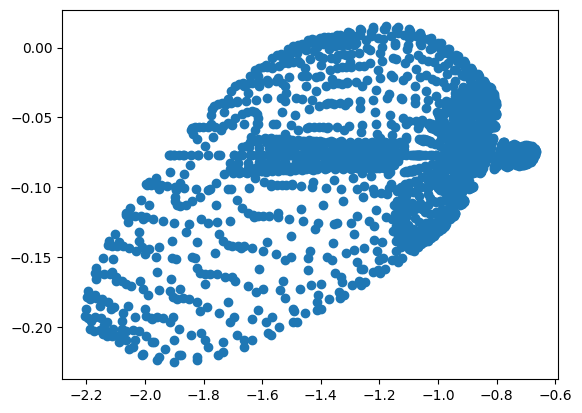

In [ ]:
display2d(model_2_est_2)

## Image to Image Projection using Mathematical Model

In [ ]:
theta = np.pi/180*(theta_1 - theta_2)

px = principal_offset[0]
py = principal_offset[1]
mx = resolution[0]
my = resolution[1]
f = focal_length

c = np.cos(theta)
s = np.sin(theta)

T_combined = np.array([
  [1 - (px*px*c / (mx*f)),     (-px/my)*((s/f) + (py*c/f)),                    px*c],
  [(-px/mx)*(my*s + (py*c/f)), (1- (py*py/(my*f)) )*c - (py + (py/(my*f)))*s,  (my*f*s)+(py*c)],
  [-px*c/(mx*f),               (-1/(my*f))*(s + (py*c)),                       c]
])

In [ ]:
def img_proj_3(x_1, T_combined):
  z = np.ones((1, x_1.shape[1]))
  x_1 = np.vstack((x_1, z))
  x = np.matmul(T_combined, x_1)
  x_new = x[0]/ x[2]
  y_new = x[1]/ x[2]
  x_2 = np.vstack((x_new, y_new))
  return x_2

### Demo: Image to Image Projection using Mathematical Model

In [ ]:
model_2_est_2 = img_proj_3(model_1, T_combined)
print(model_2_est_2.shape)

(2, 2082)


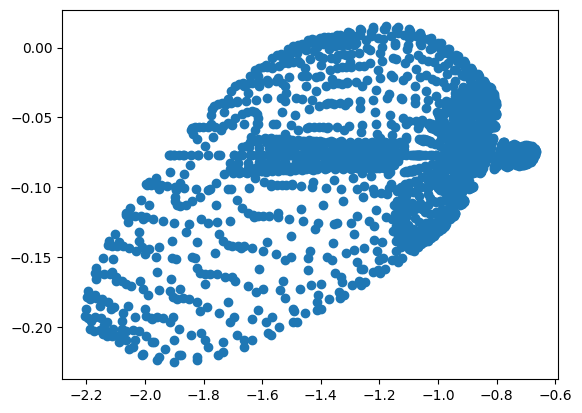

In [ ]:
display2d(model_2_est_2)

In [ ]:
if np.array_equal(model_2_est_2, model_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2, model_2_est_2)
print(mse)

8.116822014071173e-33


In [ ]:
if np.array_equal(model_2_est_2, model_2_est):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are the same! :)


In [ ]:
mse = mean_squared_error(model_2_est, model_2_est_2)
print(mse)

0.0


# Simulation across 2 Dimensions

## Rotation Matrix across 2 Dimensions

In [ ]:
def rot2d(axis_1, axis_2, alpha, beta):
  R1 = rot(axis_1, alpha)
  R2 = rot(axis_2, beta)
  return np.matmul(R1,R2)

### Demo: Rotation Matrix across 2-D

In [ ]:
alpha = 120
beta = 55
R = rot2d(0, 1, alpha, beta)

In [ ]:
rotated_obj_2 = np.matmul(R, X)
print(rotated_obj_2.shape)

(3, 2082)


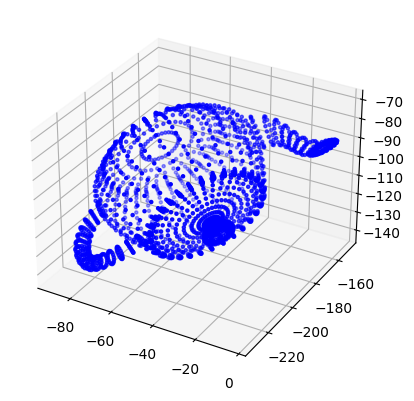

In [ ]:
display(rotated_obj_2)

## Demo: 3D to 2D Projection

In [ ]:
x = proj2d(X, R, INTRINSIC_MATRIX)

(2, 2082)


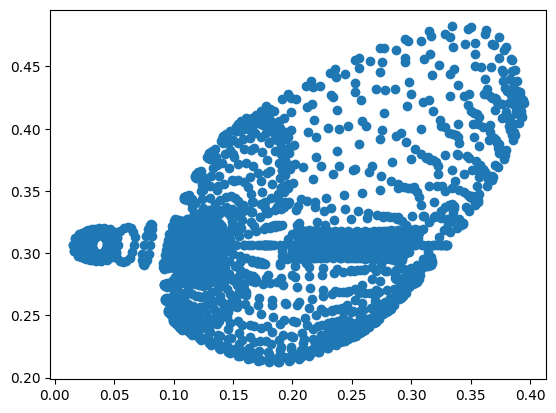

In [ ]:
display2d(x)

## Demo: 2D to 3D Projection using libraries

In [ ]:
X_new = proj3d(x, R, INTRINSIC_MATRIX)
print(X_new.shape)

(3, 2082)


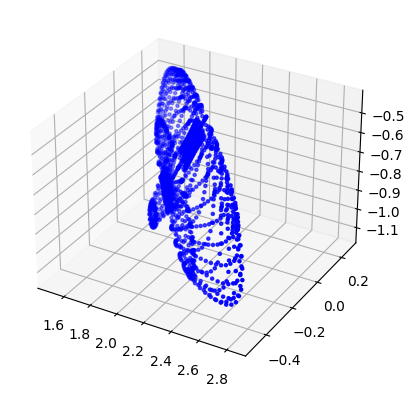

In [ ]:
display(X_new)

## Demo: 2D to 3D Projection using mathematical model

In [ ]:
R1 = rot(0, alpha)
R2 = rot(1, beta)
R_inv = np.matmul(np.transpose(R2), np.transpose(R1))

In [ ]:
X_new_2 = projInv(x, R_inv, INTRINSIC_MATRIX_INV)
print(X_new_2.shape)

(3, 2082)


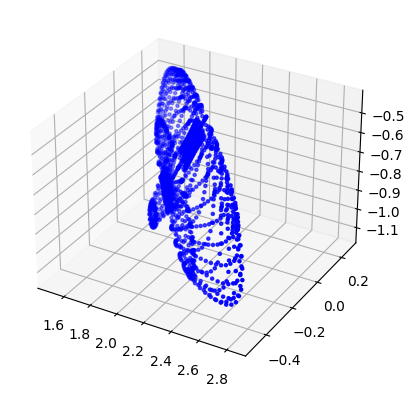

In [ ]:
display(X_new_2)

In [ ]:
if np.array_equal(X_new, X_new_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(X_new, X_new_2)
print(mse)

4.628250783038242e-32


## Image to Image Projection using Libraries

In [ ]:
model_1 = proj2d(X, rot2d(0, 1, 0, 0), INTRINSIC_MATRIX)
model_2 = proj2d(X, rot2d(0, 1, alpha, beta), INTRINSIC_MATRIX)

(2, 2082)
(2, 2082)


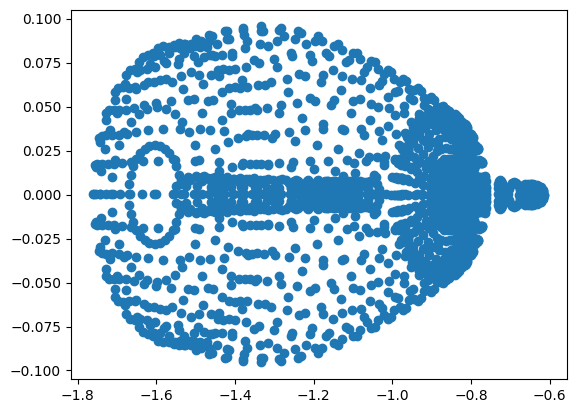

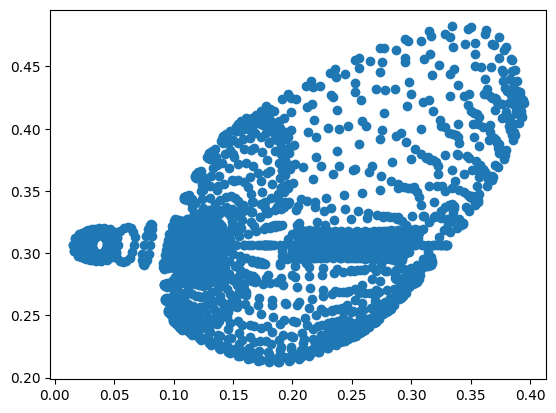

In [ ]:
display2d(model_1)
display2d(model_2)

In [ ]:
def img_proj2d(x_1, alpha, beta):
  Rx1 = rot(0, 0)
  Rx2 = rot(0, alpha)
  Ry1 = rot(1, 0)
  Ry2 = rot(1, beta)
  Ry = np.matmul(Ry2, np.linalg.inv(Ry1))
  R = np.matmul(Rx2, np.matmul(Ry, np.linalg.inv(Rx1)))
  T = np.matmul(INTRINSIC_MATRIX, np.matmul(R, np.linalg.inv(INTRINSIC_MATRIX)))
  z = np.ones((1, x_1.shape[1]))
  x_1 = np.vstack((x_1, z))
  x = np.matmul(T, x_1)
  x_new = x[0]/ x[2]
  y_new = x[1]/ x[2]
  x_2 = np.vstack((x_new, y_new))
  return x_2

### Demo: Image to Image Projection using Libraries

In [ ]:
model_2_est = img_proj2d(model_1, alpha, beta)
print(model_2_est.shape)

(2, 2082)


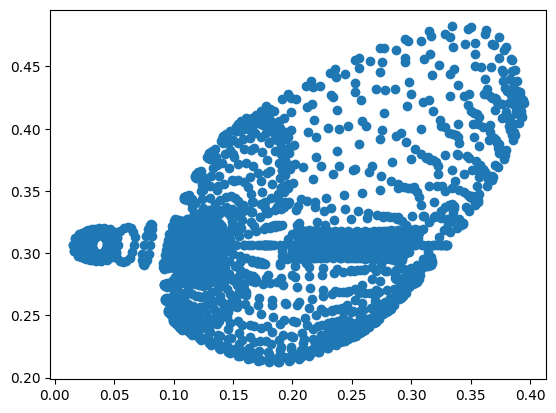

In [ ]:
display2d(model_2_est)

In [ ]:
if np.array_equal(model_2_est, model_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2, model_2_est)
print(mse)

3.4764251054459324e-33


## Image to Image Projection using combined rotation

### Testing Rotation Matrix

In [ ]:
Rx1 = rot(0, 0)
Rx2 = rot(0, alpha)
Ry1 = rot(1, 0)
Ry2 = rot(1, beta)
Ry = np.matmul(Ry2, np.transpose(Ry1))
print(Ry)
R_combined = np.matmul(Rx2, np.matmul(Ry, np.transpose(Rx1)))
print(R_combined)

[[ 0.57357644  0.          0.81915204]
 [ 0.          1.          0.        ]
 [-0.81915204  0.          0.57357644]]
[[ 0.57357644  0.          0.81915204]
 [ 0.70940648 -0.5        -0.49673176]
 [ 0.40957602  0.8660254  -0.28678822]]


In [ ]:
alpha_1 = 0
beta_1 = 0
alpha_2 = alpha
beta_2 = beta

ca1 = np.cos((np.pi/180)*alpha_1)
ca2 = np.cos((np.pi/180)*alpha_2)
ca = np.cos((np.pi/180)*(alpha_1-alpha_2))
cb1 = np.cos((np.pi/180)*beta_1)
cb2 = np.cos((np.pi/180)*beta_2)
cb = np.cos((np.pi/180)*(beta_1-beta_2))
sa1 = np.sin((np.pi/180)*alpha_1)
sa2 = np.sin((np.pi/180)*alpha_2)
sa = np.sin((np.pi/180)*(alpha_1-alpha_2))
sb1 = np.sin((np.pi/180)*beta_1)
sb2 = np.sin((np.pi/180)*beta_2)
sb = np.sin((np.pi/180)*(beta_1-beta_2))

In [ ]:
# refer to equation 31 
Ry = np.array([
    [cb, 0, -sb],
    [0,1,0],
    [sb,0,cb]
])
print(Ry)

# refer to equation 34 in report
R_combined = np.array([
    [cb, sa1*sb, -ca1*sb], 
    [-sa2*sb, ca1*ca2 + sa1*cb, sa1*ca2 - ca1*sa2*cb], 
    [ca2*sb, ca1*sa2 - sa1*ca2*cb, sa1*sa2+ca1*ca2*cb]
])
print(R_combined)

# assuming alpha_1 and beta_1 are 0
R_combined = np.array([
    [cb, 0, -sb], 
    [sa*sb, ca, sa*cb], 
    [ca*sb, -sa, ca*cb]
])
print(R_combined)

[[ 0.57357644  0.          0.81915204]
 [ 0.          1.          0.        ]
 [-0.81915204  0.          0.57357644]]
[[ 0.57357644 -0.          0.81915204]
 [ 0.70940648 -0.5        -0.49673176]
 [ 0.40957602  0.8660254  -0.28678822]]
[[ 0.57357644  0.          0.81915204]
 [ 0.70940648 -0.5        -0.49673176]
 [ 0.40957602  0.8660254  -0.28678822]]


### Testing intermediate matrix M = KR

In [ ]:
M = np.array([
    [(mx*f*cb)+(px*ca*sb), -px*sa, (-mx*f*sb) + (px*ca*cb)],
    [(my*f*sa*sb)+(py*ca*sb), (my*f*ca)-(py*sa), (my*f*sa*cb)+(py*ca*cb)],
    [ca*sb, -sa, ca*cb]
])

In [ ]:
x_1 = model_1
T = np.matmul(M, np.linalg.inv(INTRINSIC_MATRIX))
z = np.ones((1, x_1.shape[1]))
x_1 = np.vstack((x_1, z))
x = np.matmul(T, x_1)
x_new = x[0]/ x[2]
y_new = x[1]/ x[2]
x_test = np.vstack((x_new, y_new))

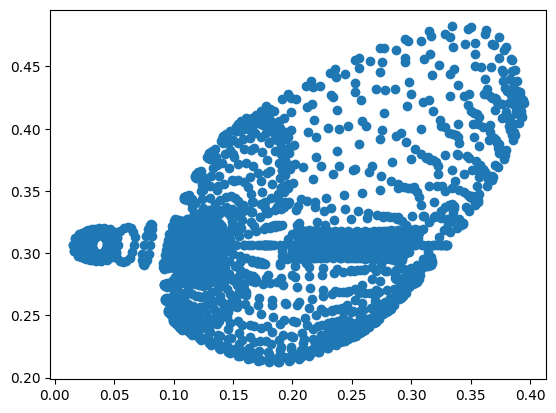

In [ ]:
display2d(x_test)

### Demo: Image to Image Projection using combined rotation

In [ ]:
model_2_est_2 = img_proj_2(model_1, R_combined)
print(model_2_est_2.shape)

(2, 2082)


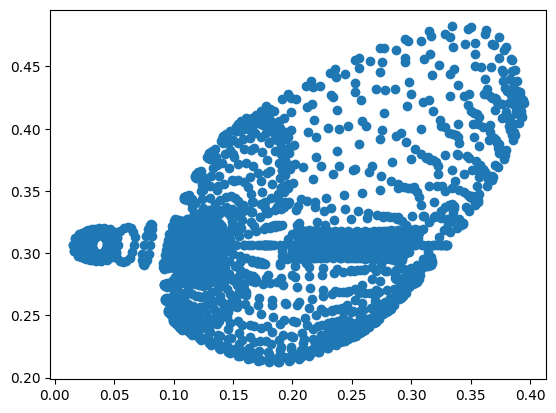

In [ ]:
display2d(model_2_est_2)

In [ ]:
if np.array_equal(model_2_est_2, model_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2_est_2, model_2)
print(mse)

3.4764251054459324e-33


In [ ]:
if np.array_equal(model_2_est_2, model_2_est):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are the same! :)


In [ ]:
mse = mean_squared_error(model_2_est_2, model_2_est)
print(mse)

0.0


## Image to Image Projection using Mathematical Model

In [ ]:
T_combined = np.array([
  [ cb*(1 - (px*px*ca / (mx*f))) + sb*((px*ca/(mx*f)) + px),     
    sb*((my*sa/mx) + (py*ca/(mx*f))) - cb*((my*px*sa/mx) + (px*py*ca/ (mx*f))),                    
    ca*((sb/(mx*f)) - (px*cb/(mx*f)))],
  [ (-1/(my*f))*((px*sa) - (mx*f*py*sb) + (px*py*ca*cb)), 
    (1 - (py*py*cb/(my*f)) )*ca - ((py*cb) + (py/(my*f)))*sa,  
    (-1/(my*f))*(sa + (py*ca*cb))],
  [ (-mx*f*sb)+(px*ca*cb),               
    cb*((my*f*sa) + (py*ca)),                       
    ca*cb]
])

T_combined = np.transpose(T_combined)

### Demo: Image to Image Projection using Mathematical Model

In [ ]:
model_2_est_2 = img_proj_3(model_1, T_combined)
print(model_2_est_2.shape)

(2, 2082)


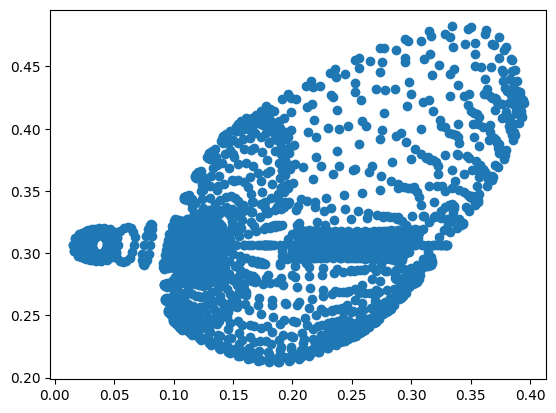

In [ ]:
display2d(model_2_est_2)

In [ ]:
if np.array_equal(model_2_est_2, model_2):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2_est_2, model_2)
print(mse)

3.888807223221067e-33


In [ ]:
if np.array_equal(model_2_est_2, model_2_est):
  print('Transformations are the same! :)')
else:
  print('Transformations are not the same! :(')

Transformations are not the same! :(


In [ ]:
mse = mean_squared_error(model_2_est_2, model_2_est)
print(mse)

2.691861737832304e-34


# Principal Point Estimation

In [ ]:
T_combined = np.array([
  [ cb,     
    sb*(my*sa/mx),                    
    ca*sb/(mx*f)],
  [ 0, 
    ca,  
    (-1/(my*f))*sa],
  [ (-mx*f*sb),               
    cb*(my*f*sa),                       
    ca*cb]
])

T_combined = np.transpose(T_combined)

In [ ]:
model_2_est_2 = img_proj_3(model_1, T_combined)
print(model_2_est_2.shape)

(2, 2082)


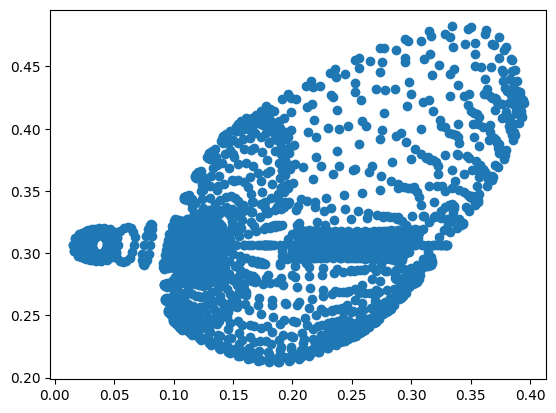

In [ ]:
display2d(model_2_est_2)

# Estimating angles of rotation

In [ ]:
x_est = model_2[:,50]
print(x_est)

[0.09911173 0.24648816]


In [ ]:
x = model_1[:,50]
print(x)

[-0.81080574 -0.03841982]


In [ ]:
def get_beta(x, x_est):
  a = (x[0]*x[0]) + (mx*mx*f*f)
  b = 2*x_est[0]*mx*f
  c = (x[0]*x[0]) - (x_est[0]*x_est[0])
  pt1 = (-b/(2*a))
  pt2 = np.sqrt((b**2)+(4*a*c))/(2*a)
  b1 = np.arcsin(pt1+pt2) * (180/np.pi)
  b2 = np.arcsin(pt1-pt2) * (180/np.pi)
  return b1, b2

In [ ]:
def get_alpha(beta, x, x_est):
  sb_est = np.sin(beta_est)
  cb_est = np.cos(beta_est)  
  u = (sb_est*x[0]/(mx*f)) + cb_est
  v = (x_est[1] * (u)) - x[1]
  w = (my*f*u*u) + (x[1]*x[1]/ (my*f))
  # estimating sin alpha
  sin_alpha = v / w
  alpha = np.arcsin(sin_alpha) * 180/np.pi
  # estimating cos alpha
  cos_alpha = (1 + ((sin_alpha*x[1])/(my*f))) / u 
  alpha_2 = np.arccos(cos_alpha) * 180/np.pi
  return 180 - alpha, 180 - alpha_2

In [ ]:
beta_est = get_beta(x, x_est)
beta_est = beta_est[0]
print(beta_est)

56.75388841593088


In [ ]:
alpha_est = get_alpha(beta_est, x, x_est)
alpha_est = alpha_est[1]
print(alpha_est)

136.36150149652377


<ipython-input-385-63019c5fd804>:9: RuntimeWarning: invalid value encountered in arcsin
  alpha = np.arcsin(sin_alpha) * 180/np.pi


In [ ]:
print('alpha:', alpha, 'beta:', beta)
beta_err = np.absolute((beta_est-beta)*100/beta)
alpha_err = np.absolute((alpha_est-alpha)*100/alpha)
print(alpha_err, beta_err)

alpha: 120 beta: 55
13.634584580436476 3.1888880289652377


In [ ]:
R = rot2d(0, 1, alpha_est, beta_est)

In [ ]:
rotated_obj_3 = np.matmul(R, X)
print(rotated_obj_3.shape)

(3, 2082)


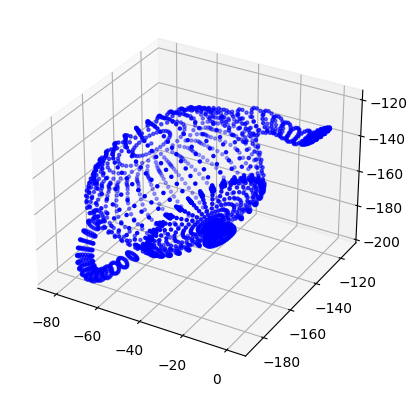

In [ ]:
display(rotated_obj_3)

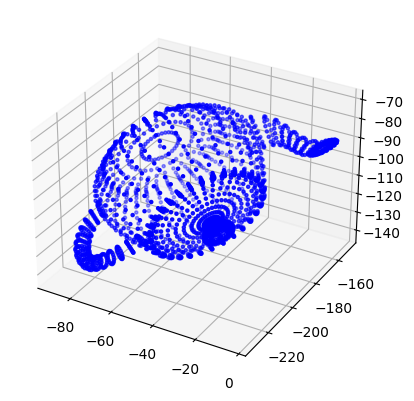

In [ ]:
display(rotated_obj_2)

In [ ]:
mse = mean_squared_error(rotated_obj_2, rotated_obj_3)
print(mse)

1351.2545589086535
